In [1]:
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, Aug_Koopman_ModelQP, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
import csv
import pickle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

In [2]:
file_name_results = 'Air_Passenger_Hankel_EDMD'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")  

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/Air_Passenger_Hankel_EDMD/  already exists, overwriting results


Text(0, 0.5, 'y')

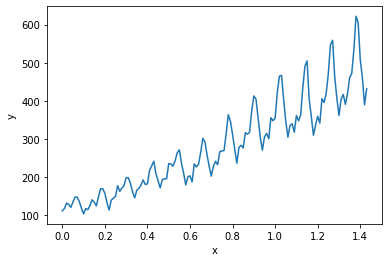

In [3]:
np.random.seed(42)
dim = 1
true_y = np.genfromtxt('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', delimiter=',')[1:,1]


csvfile = open('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', 'r')
reader = csv.reader(csvfile, delimiter='\t')
my_list = list(reader)
dates = []
dates_to_plot = []
for i in range(144):
    dates.append(my_list[1+i][0][:7].replace("-", "/"))
    dates_to_plot.append('')
formated_dates = [dt.datetime.strptime(d,'%Y/%m').date() for d in dates]
true_t = np.linspace(0, (true_y.shape[0]-1)/100, true_y.shape[0])
plt.plot(true_t,true_y)
plt.xlabel("x")
plt.ylabel("y")

In [4]:
# data
dt   = true_t[1]-true_t[0]
S_train = true_y[:100].reshape(1,-1,1)
S_test  = true_y[100:].reshape(1,-1,1)
T_train = true_t[:100].reshape(1,-1,1)
T_test  = true_t[100:].reshape(1,-1,1)
Batch_size = S_train.shape[1]
X_train = S_train[0,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = int(X_train.shape[0]/Batch_size)
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
T_train = torch.from_numpy(T_train.reshape(nb_Batch,Batch_size,dim)).double()
batch_size_test = X_test.shape[1]
nb_batch_test   = int(X_test.shape[1]/batch_size_test)
X_test  = torch.from_numpy(X_test[:,:,:].reshape(nb_batch_test,batch_size_test,-1)).double()
T_test  = torch.from_numpy(T_test[:,:,:].reshape(nb_batch_test,batch_size_test,-1)).double()
X_train = X_train[0,:,:]
X_test = X_test[0,:,:]

In [5]:
params = {}
params['length_embed'] = 20
params['delay_embed']  = 1
# In[]
H = X_train.T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    H = np.concatenate((H,X_train.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
H = np.concatenate((H,X_train.T[:,params['length_embed']*params['delay_embed']:]))
# In[]
HT = X_test.T[:,:-(params['length_embed']*params['delay_embed'])]
for i in range(1,params['length_embed']):
    HT = np.concatenate((HT,X_test.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))


In [6]:
svd = TruncatedSVD(n_components=14, n_iter=7, random_state=42)
v = svd.fit_transform(H.T)
Train_X_EDMD = v[:-1,:]
Train_Y_EDMD = v[1:,:]
A_EDMD  = np.dot(np.linalg.pinv(Train_X_EDMD[:,:]),Train_Y_EDMD[:,:]).T
# In[]
pred_EDMD = np.zeros((X_test.shape[0],Train_Y_EDMD.shape[-1]))# np.zeros_like(X_test)
v_init = svd.transform(HT.T)
pred_EDMD[:1,:] =Train_Y_EDMD[-1:,:]# v_init[:1,:]
for i in range(X_test.shape[0]-1):
    pred_EDMD[i+1,:] = np.dot(A_EDMD,pred_EDMD[i,:].T).T
pred_EDMD_VDP = svd.inverse_transform(pred_EDMD)


In [7]:
out_res = {}
out_res['train_data'] = X_train.detach().numpy()
out_res['test_data'] = X_test.detach().numpy()
out_res['dt']  =dt
out_res['infered_test']  = pred_EDMD_VDP[1:44+1,-1:]
pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

In [8]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

In [9]:
def R_C_E(y_true, y_pred): 
    return (np.sum((y_true - (y_pred))**2)/ np.sum(y_true**2)) *100

In [10]:
test_batch = res['test_data']
pred_batch = res['infered_test'][:,:]

print(R_C_E(test_batch[:,0][:22],pred_batch[:,0][:22]))
print(R_C_E(test_batch[:,0][22:43],pred_batch[:,0][22:43]))

0.8816995090511438
2.292936654301351


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


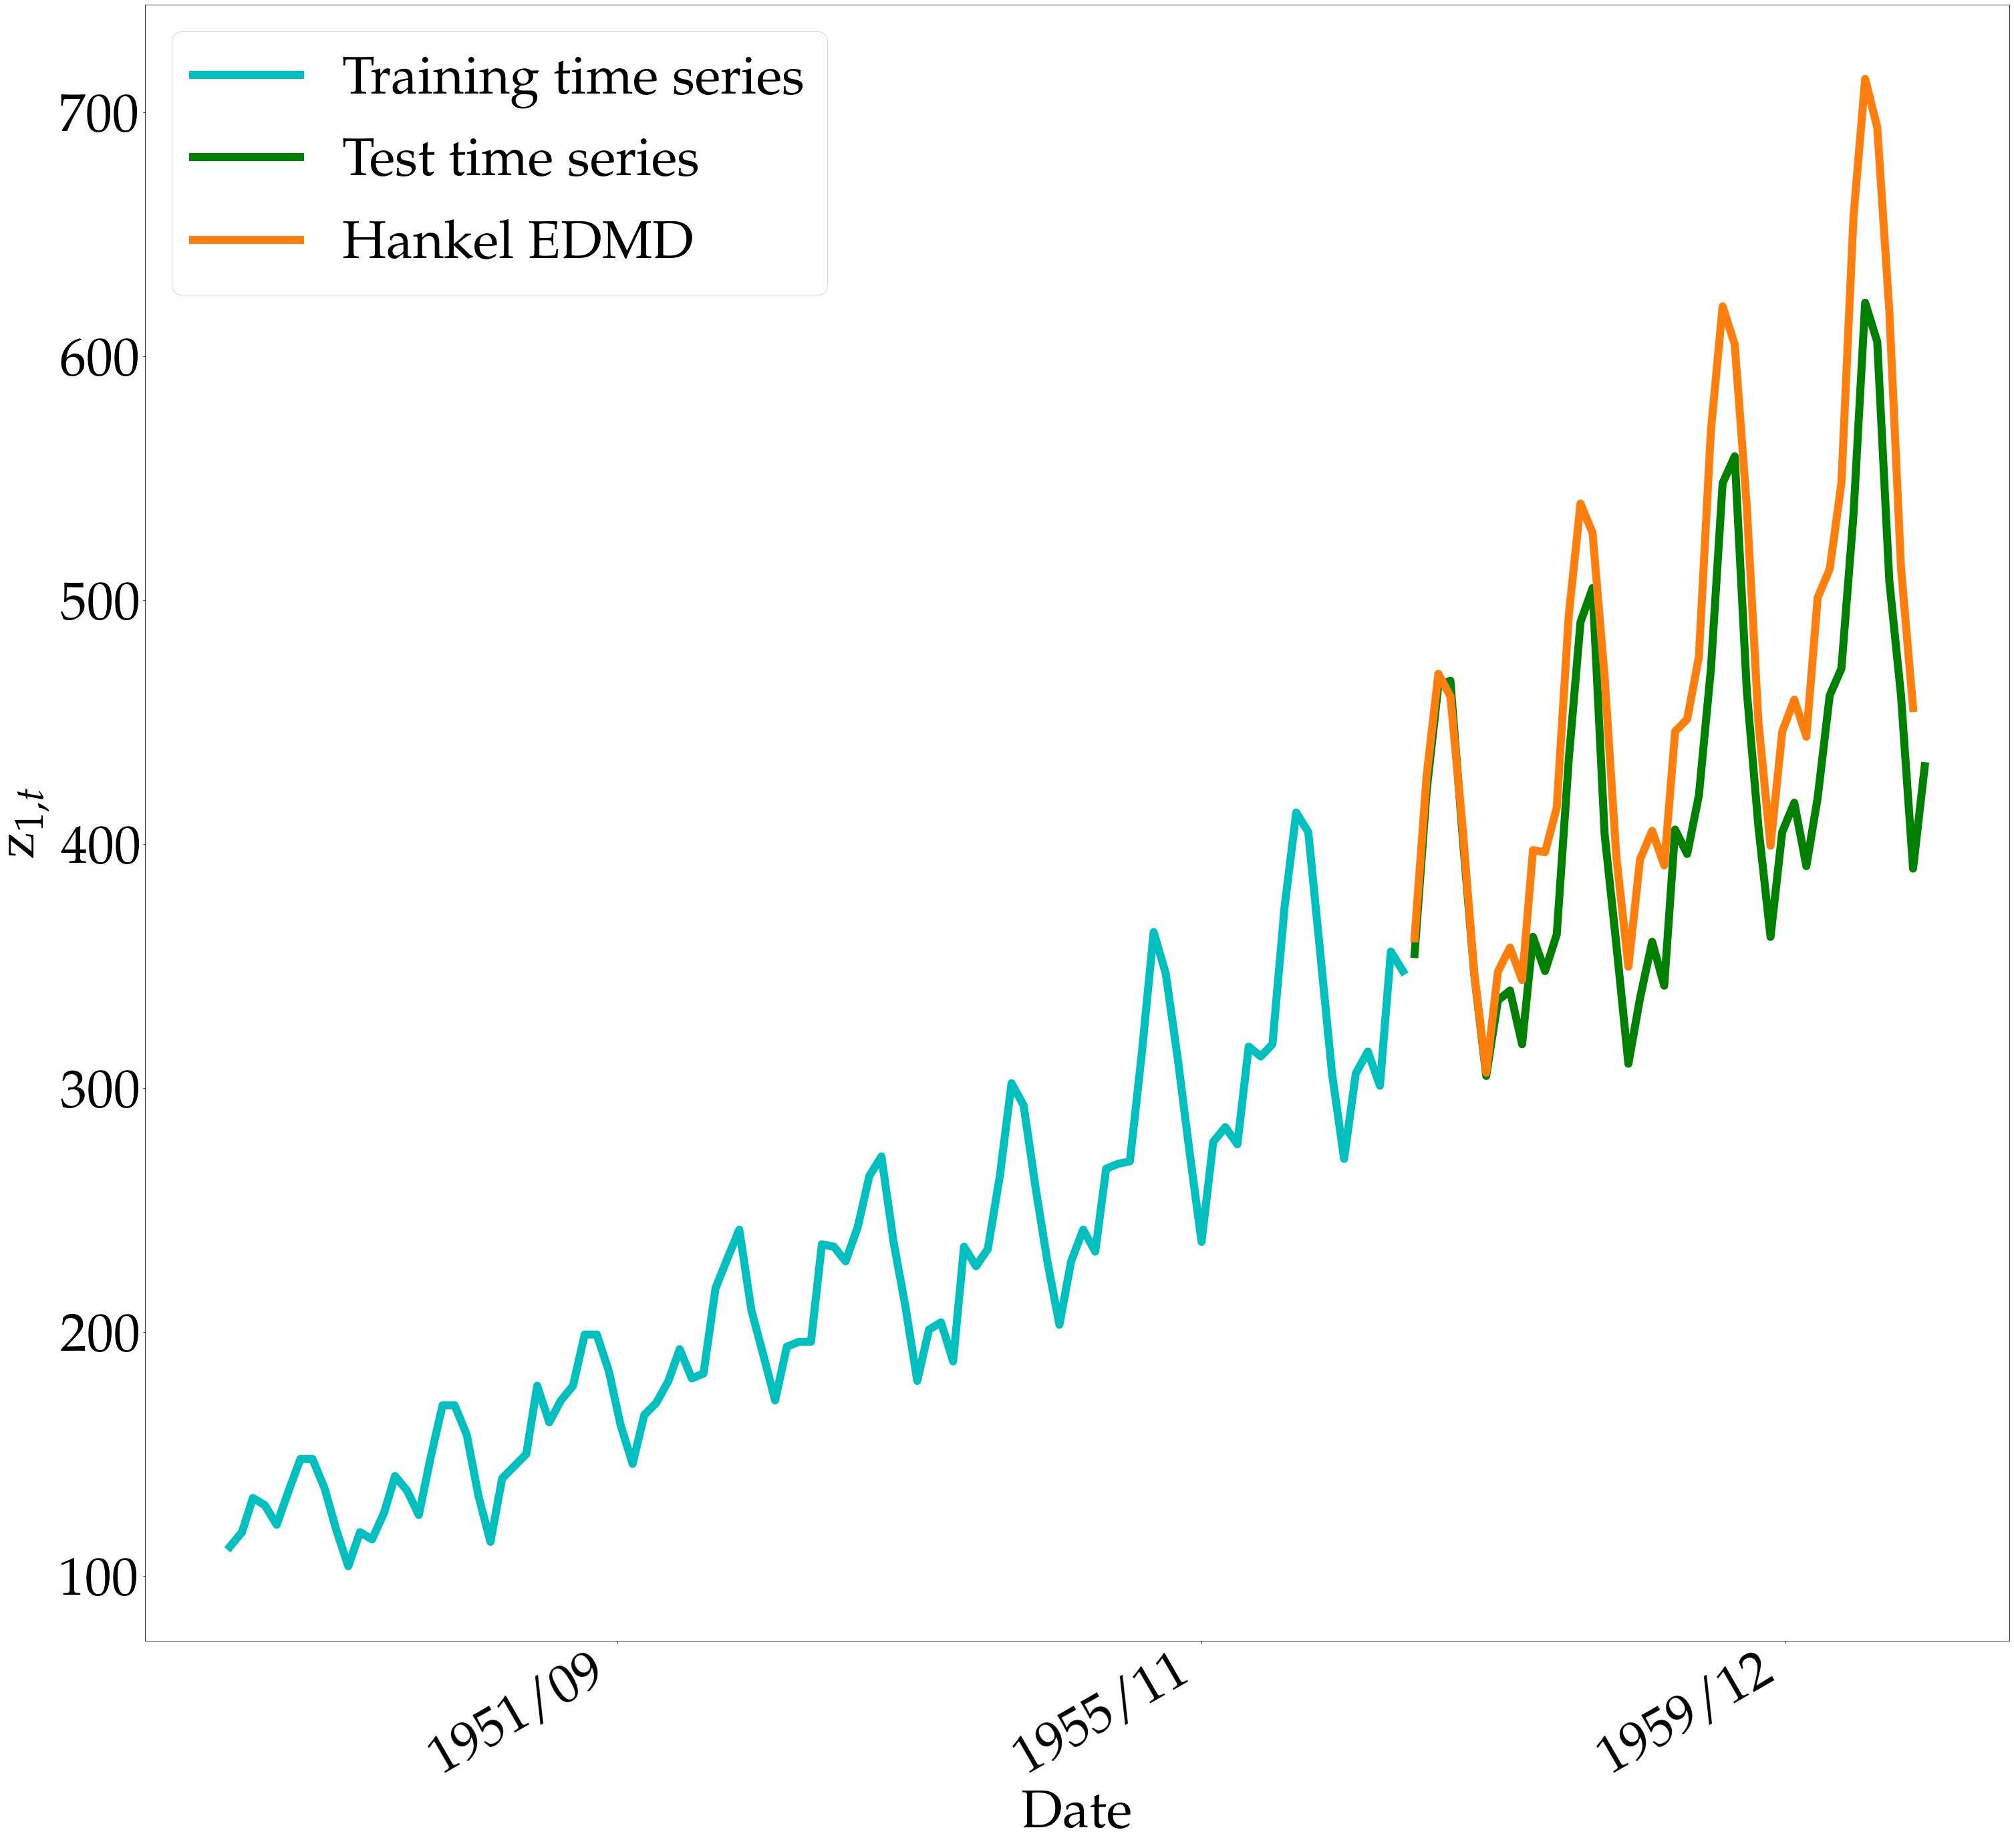

In [11]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros((res['train_data'].shape[0]+res['test_data'].shape[0],1))*np.nan
test_series      = np.zeros((res['train_data'].shape[0]+res['test_data'].shape[0],1))*np.nan
predicted_series = np.zeros((res['train_data'].shape[0]+res['test_data'].shape[0],1))*np.nan
train_series[:res['train_data'].shape[0],:]     = res['train_data'][:,:]
test_series[res['train_data'].shape[0]:,:]      = res['test_data'][:,:]
predicted_series[res['train_data'].shape[0]:-1,:] = res['infered_test'][:,:1]

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1500))
plt.plot(formated_dates,train_series,lw = 12,c = 'c',label = 'Training time series')
plt.plot(formated_dates,test_series,lw = 12,c = 'g',label = 'Test time series')
plt.plot(formated_dates,predicted_series,lw = 12,c = 'tab:orange',label = 'Hankel EDMD')
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('${\mathrm{z}}_{1,t}$')
plt.legend(markerscale=2)